# import libraires

In [1]:
#unzip the file im colab
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Spam_Email.zip', 'r') as zip_ref:
    zip_ref.extractall('Spam_Email')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn import metrics
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# download necessary nltk resources
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
from collections import Counter
from wordcloud import WordCloud
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Dropout,Activation,Bidirectional
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# load dataset

In [70]:
df = pd.read_csv("Spam_Email/combined_data.csv")

# Text preprocess

In [71]:
# define the set of english stopwords
STOPWORDS = set(stopwords.words('english'))
# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

#define a function to preprocess text
def preprocess_text(text):
    #convert to lowercase
    text = text.lower()
    #remove URL
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    #remove html tags
    text = re.sub(r'<.*?>', '', text)
    #remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    #tokenize the text
    tokens = word_tokenize(text)
    #remove stopwords and apply lemmatization
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in STOPWORDS and word.isalpha()
    ]
    #return the preprocessed text
    return ' '.join(tokens)

In [72]:
# apply preprocess text
df['clean_text'] = df['text'].apply(preprocess_text)

In [73]:
df.head(10)

,label,text,clean_text
0,1,ounce feather bowl hummingbird opec moment ala...,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...,wulvob get medircations online qnb ikud viagra...
2,0,computer connection from cnn com wednesday es...,computer connection cnn com wednesday escapenu...
3,1,university degree obtain a prosperous future m...,university degree obtain prosperous future mon...
4,0,thanks for all your answers guys i know i shou...,thanks answer guy know checked rsync manual wo...
5,0,larry king live at escapenumber escapenumber p...,larry king live escapenumber escapenumber p et...
6,0,michael pobega wrote i'm not sure if it's the ...,michael pobega wrote im sure mpl mozilla didnt...
7,0,hi i have this error tr sample escapenumber es...,hi error tr sample escapenumber escapenumber e...
8,1,works gateway world art explore tattooing full...,work gateway world art explore tattooing full ...
9,1,upon this account he is not only very cautious...,upon account cautious escapenumber men would w...


In [78]:
#initialize a counter to count word frequencies
word_count = Counter()
for text in df['clean_text']:
    for word in text.split():
        word_count[word] += 1

# display 10 most common word
word_count.most_common(10)

[('please', 39129),
 ('e', 38962),
 ('help', 38238),
 ('list', 38102),
 ('www', 38028),
 ('new', 37123),
 ('one', 36689),
 ('company', 36667),
 ('may', 36310),
 ('time', 35213)]

In [76]:
# identify the 10 most frequent words
FREQUENT_WORDS = set(word for (word, wc) in word_count.most_common(10))

# define a function to remove frequent words from text
def remove_freq_words(text):
    return " ".join([word for word in text.split() if word not in FREQUENT_WORDS])

In [77]:
#remove 10 most common word
df['clean_text'] = df['clean_text'].apply(lambda x: remove_freq_words(x))

# Word Cloud

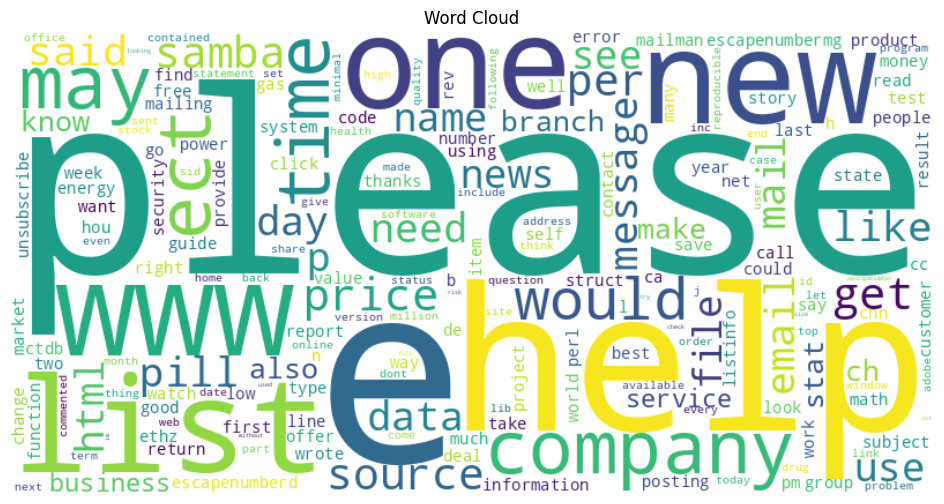

In [86]:
#visualize the word cloud
top_word= dict(word_count.most_common(200))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_word)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

# LSTM

In [11]:
#split the text and label
X_train, X_test, y_train, y_test =train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

In [12]:
#print the shape
print(X_train.shape)
print(X_test.shape)

(66758,)
(16690,)


In [13]:
vocab_size = 20000
max_len = 2000

#initialize tokenizer with a vocabulary size
tokenize = Tokenizer(num_words=vocab_size)
tokenize.fit_on_texts(X_train)

#convert texts to sequences
X_train_seq = tokenize.texts_to_sequences(X_train)
X_test_seq = tokenize.texts_to_sequences(X_test)

In [14]:
#pad the training and testing sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [15]:
# print padding shape
X_train_padded.shape

(66758, 2000)

In [16]:
#build network model
model = Sequential([
    Embedding(vocab_size, 32, input_length=max_len),
    Bidirectional(LSTM(64)),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
#compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
#train the model
history = model.fit(X_train_padded, y_train,
                    batch_size=512,
                    epochs=5,
                    validation_data=(X_test_padded, y_test))

Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 49s 318ms/step - accuracy: 0.7827 - loss: 0.3942 - val_accuracy: 0.9757 - val_loss: 0.0742
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 332ms/step - accuracy: 0.9811 - loss: 0.0637 - val_accuracy: 0.9861 - val_loss: 0.0477
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 83s 340ms/step - accuracy: 0.9914 - loss: 0.0319 - val_accuracy: 0.9861 - val_loss: 0.0480
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 341ms/step - accuracy: 0.9950 - loss: 0.0216 - val_accuracy: 0.9851 - val_loss: 0.0528
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 333ms/step - accuracy: 0.9954 - loss: 0.0185 - val_accuracy: 0.9840 - val_loss: 0.0531


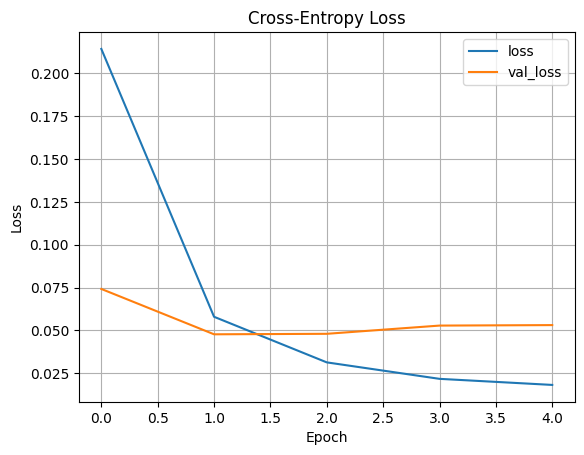

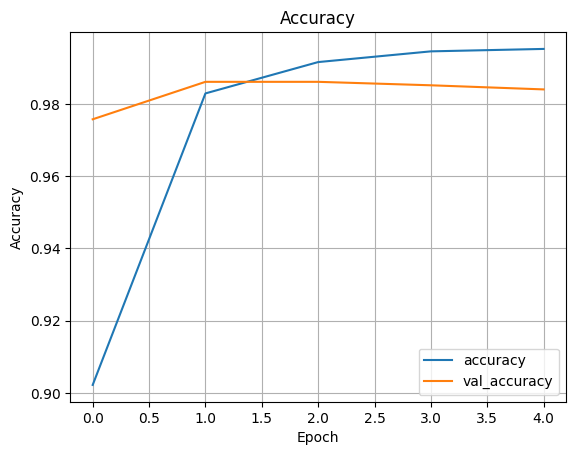

In [19]:
history_df = pd.DataFrame(history.history)

#compare the model loss against validation loss
history_df[['loss', 'val_loss']].plot(title="Cross-Entropy Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

#compare the model accuracy against the actual val accuracy
history_df[['accuracy', 'val_accuracy']].plot(title="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [20]:
# make predictions on the test set
y_pred = model.predict(X_test_padded)
# convert the predictions to binary labels
y_pred_lstm = [1 if pred > 0.5 else 0 for pred in y_pred]

522/522 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step


In [22]:
# Calculate performance metrics
acc = metrics.accuracy_score(y_test, y_pred_lstm)
prec = metrics.precision_score(y_test, y_pred_lstm)
rec = metrics.recall_score(y_test, y_pred_lstm)
f1 = metrics.f1_score(y_test, y_pred_lstm)

#print the calculated metrics
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9840
Precision: 0.9860
Recall: 0.9834
F1 Score: 0.9847


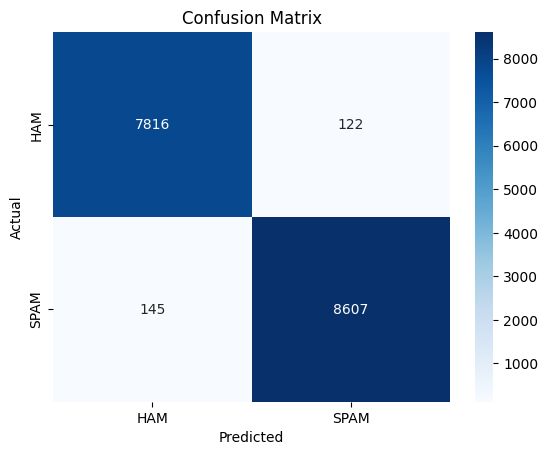

In [21]:
#visualize the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_lstm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
ax.xaxis.set_ticklabels(['HAM', 'SPAM']); ax.yaxis.set_ticklabels(['HAM', 'SPAM']);
plt.show()

# Naive Bayes

In [23]:
#define X,y
X=df['clean_text']
y=df['label']

In [24]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
#initialize a TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [26]:
#print spilt shape
print(X_train.shape, X_test.shape)

(66758,) (16690,)


In [27]:
# initialize naive bayes model
naive = MultinomialNB()
# train the model
naive.fit(X_train_tfidf, y_train)

MultinomialNB()

In [28]:
# predictions
y_pred_naive = naive.predict(X_test_tfidf)

In [30]:
# Calculate performance metrics
acc = metrics.accuracy_score(y_test, y_pred_naive)
prec = metrics.precision_score(y_test, y_pred_naive)
rec = metrics.recall_score(y_test, y_pred_naive)
f1 = metrics.f1_score(y_test, y_pred_naive)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9747
Precision: 0.9888
Recall: 0.9626
F1 Score: 0.9756


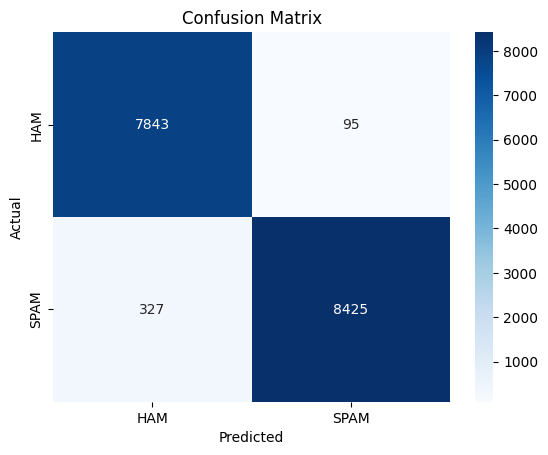

In [29]:
#vizuilaze the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_naive)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
ax.xaxis.set_ticklabels(['HAM', 'SPAM']); ax.yaxis.set_ticklabels(['HAM', 'SPAM']);
plt.show()

# Save Model and Tokenizer

In [31]:
#save the model
model.save("Spam_Email.h5")

In [32]:
#save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenize, f)

# Sample Predictions

In [34]:
# define a function to predict if a mail is spam or ham using lstm model
def predict(mail):
    #preprocess the mail text
    clean_mail= preprocess_text(mail)
    #convert the cleaned mail to sequences
    sequence = tokenize.texts_to_sequences([clean_mail])
    #pad the sequences
    padding= pad_sequences(sequence, maxlen=max_features, padding='post', truncating='post')
    #make a prediction
    pred= model.predict(padding)[0][0]
    #determine the mail is spam or ham
    sentiment= "Spam" if pred > 0.5 else "HAM"

    # print the original text, cleaned text, and prediction
    print("Text: ",mail)
    print("Clean: ",clean_mail)
    print(f"Email: {sentiment},  Score: {pred:.4f}")

In [95]:
def predict_naive(mail):
    #preprocess the mail text
    clean_mail= preprocess_text(mail)
    #transform the cleaned text using the tf-idf vectorizer
    text_vec= vectorizer.transform([clean_mail])
    #predict the label using the naive bayes model
    prediction= naive.predict(text_vec)
    #determine the mail is spam or ham
    sentiment_naive= "Spam" if prediction[0] > 0.5 else "HAM"

    # print the original text, cleaned text, and prediction
    print("Text: ",mail)
    print("Clean: ",clean_mail)
    print(f"Email: {sentiment_naive},  Score: {prediction[0]:.4f}")

In [88]:
predict("dear christ time come christian worship god spirit truth according book john chapter vsescapenumber hour cometh true worshiper shall worship father spirit truth father seeketh worship god spirit worship must worship spirit truth based scripture became obvious right thing must enter kingdom god deacon leonard ashley legal adviser late mr mike carol hall god fearing dedicated couple wealthy child travelled patong thailand christmas holiday met death escapenumberth december tsunami disaster news bbc co uk hi england bristol stm legal adviser death husband mr mike hall instructed write child dedicated wealth god lot landed property house stock bond etc according instruction according asset given ministry work god legal adviser document fund deposited vault company care born christian reading bible lawful right sight god giving fund chosen ministry purpose god work instructed owner death fasting prayer today asked god make choice direct honest christian chosen ministry deserves fund grace came across address internet appeal use fund wisely thing glorify name god also could get back visiting website enable discus clarifying manner best understanding must say im uncomfortable sending message without knowing truly would misconstrue importance decides go public regard hold back say essence message strictly charity may god bless make mind work god thanks elizabeth deacon leonard ashley")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
Text:  dear christ time come christian worship god spirit truth according book john chapter vsescapenumber hour cometh true worshiper shall worship father spirit truth father seeketh worship god spirit worship must worship spirit truth based scripture became obvious right thing must enter kingdom god deacon leonard ashley legal adviser late mr mike carol hall god fearing dedicated couple wealthy child travelled patong thailand christmas holiday met death escapenumberth december tsunami disaster news bbc co uk hi england bristol stm legal adviser death husband mr mike hall instructed write child dedicated wealth god lot landed property house stock bond etc according instruction according asset given ministry work god legal adviser document fund deposited vault company care born christian reading bible lawful right sight god giving fund chosen ministry purpose god work instructed owner death fasting prayer today asked god make choice direct honest c

In [94]:
predict_naive("dear christ time come christian worship god spirit truth according book john chapter vsescapenumber hour cometh true worshiper shall worship father spirit truth father seeketh worship god spirit worship must worship spirit truth based scripture became obvious right thing must enter kingdom god deacon leonard ashley legal adviser late mr mike carol hall god fearing dedicated couple wealthy child travelled patong thailand christmas holiday met death escapenumberth december tsunami disaster news bbc co uk hi england bristol stm legal adviser death husband mr mike hall instructed write child dedicated wealth god lot landed property house stock bond etc according instruction according asset given ministry work god legal adviser document fund deposited vault company care born christian reading bible lawful right sight god giving fund chosen ministry purpose god work instructed owner death fasting prayer today asked god make choice direct honest christian chosen ministry deserves fund grace came across address internet appeal use fund wisely thing glorify name god also could get back visiting website enable discus clarifying manner best understanding must say im uncomfortable sending message without knowing truly would misconstrue importance decides go public regard hold back say essence message strictly charity may god bless make mind work god thanks elizabeth deacon leonard ashley")

SPAM
Text:  dear christ time come christian worship god spirit truth according book john chapter vsescapenumber hour cometh true worshiper shall worship father spirit truth father seeketh worship god spirit worship must worship spirit truth based scripture became obvious right thing must enter kingdom god deacon leonard ashley legal adviser late mr mike carol hall god fearing dedicated couple wealthy child travelled patong thailand christmas holiday met death escapenumberth december tsunami disaster news bbc co uk hi england bristol stm legal adviser death husband mr mike hall instructed write child dedicated wealth god lot landed property house stock bond etc according instruction according asset given ministry work god legal adviser document fund deposited vault company care born christian reading bible lawful right sight god giving fund chosen ministry purpose god work instructed owner death fasting prayer today asked god make choice direct honest christian chosen ministry deserves 

In [100]:
predict("alert name bush wife evangelist billy graham dy pm edt evangelist billy graham wife ruth died thursday family spokeswoman said full story agreed receive email cnn result cnn preference setting manage setting click alter alter alert criterion frequency unsubscribe receiving custom email alert click refer friend colleague cnns free personalized alerting service cable news network lp lllp one cnn center atlanta georgia cable news network lp lllp time warner company right reserved term service provided read privacy guideline contact")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
Text:  alert name bush wife evangelist billy graham dy pm edt evangelist billy graham wife ruth died thursday family spokeswoman said full story agreed receive email cnn result cnn preference setting manage setting click alter alter alert criterion frequency unsubscribe receiving custom email alert click refer friend colleague cnns free personalized alerting service cable news network lp lllp one cnn center atlanta georgia cable news network lp lllp time warner company right reserved term service provided read privacy guideline contact
Clean:  alert name bush wife evangelist billy graham dy pm edt evangelist billy graham wife ruth died thursday family spokeswoman said full story agreed receive email cnn result cnn preference setting manage setting click alter alter alert criterion frequency unsubscribe receiving custom email alert click refer friend colleague cnns free personalized alerting service cable news network lp lllp one cnn center atlanta

In [99]:
predict_naive("alert name bush wife evangelist billy graham dy pm edt evangelist billy graham wife ruth died thursday family spokeswoman said full story agreed receive email cnn result cnn preference setting manage setting click alter alter alert criterion frequency unsubscribe receiving custom email alert click refer friend colleague cnns free personalized alerting service cable news network lp lllp one cnn center atlanta georgia cable news network lp lllp time warner company right reserved term service provided read privacy guideline contact")

Text:  alert name bush wife evangelist billy graham dy pm edt evangelist billy graham wife ruth died thursday family spokeswoman said full story agreed receive email cnn result cnn preference setting manage setting click alter alter alert criterion frequency unsubscribe receiving custom email alert click refer friend colleague cnns free personalized alerting service cable news network lp lllp one cnn center atlanta georgia cable news network lp lllp time warner company right reserved term service provided read privacy guideline contact
Clean:  alert name bush wife evangelist billy graham dy pm edt evangelist billy graham wife ruth died thursday family spokeswoman said full story agreed receive email cnn result cnn preference setting manage setting click alter alter alert criterion frequency unsubscribe receiving custom email alert click refer friend colleague cnns free personalized alerting service cable news network lp lllp one cnn center atlanta georgia cable news network lp lllp tim

In [102]:
predict("along zeng wrote hi levene test could give advice levene test thanks lot waiting try rsitesearch levene restrict function point funtion car package help stat math ethz ch mailing list stat ethz ch mailman listinfo help read posting guide www project posting guide html provide commented minimal self contained reproducible code chuck cleland ph ndri inc west escapenumberrd street escapenumberth floor new york ny tel tu th tel w f fax help stat math ethz ch mailing list stat ethz ch mailman listinfo help read posting guide www project posting guide html provide commented minimal self contained reproducible code")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
Text:  along zeng wrote hi levene test could give advice levene test thanks lot waiting try rsitesearch levene restrict function point funtion car package help stat math ethz ch mailing list stat ethz ch mailman listinfo help read posting guide www project posting guide html provide commented minimal self contained reproducible code chuck cleland ph ndri inc west escapenumberrd street escapenumberth floor new york ny tel tu th tel w f fax help stat math ethz ch mailing list stat ethz ch mailman listinfo help read posting guide www project posting guide html provide commented minimal self contained reproducible code
Clean:  along zeng wrote hi levene test could give advice levene test thanks lot waiting try rsitesearch levene restrict function point funtion car package help stat math ethz ch mailing list stat ethz ch mailman listinfo help read posting guide www project posting guide html provide commented minimal self contained reproducible code ch

In [103]:
predict_naive("along zeng wrote hi levene test could give advice levene test thanks lot waiting try rsitesearch levene restrict function point funtion car package help stat math ethz ch mailing list stat ethz ch mailman listinfo help read posting guide www project posting guide html provide commented minimal self contained reproducible code chuck cleland ph ndri inc west escapenumberrd street escapenumberth floor new york ny tel tu th tel w f fax help stat math ethz ch mailing list stat ethz ch mailman listinfo help read posting guide www project posting guide html provide commented minimal self contained reproducible code")

Text:  along zeng wrote hi levene test could give advice levene test thanks lot waiting try rsitesearch levene restrict function point funtion car package help stat math ethz ch mailing list stat ethz ch mailman listinfo help read posting guide www project posting guide html provide commented minimal self contained reproducible code chuck cleland ph ndri inc west escapenumberrd street escapenumberth floor new york ny tel tu th tel w f fax help stat math ethz ch mailing list stat ethz ch mailman listinfo help read posting guide www project posting guide html provide commented minimal self contained reproducible code
Clean:  along zeng wrote hi levene test could give advice levene test thanks lot waiting try rsitesearch levene restrict function point funtion car package help stat math ethz ch mailing list stat ethz ch mailman listinfo help read posting guide www project posting guide html provide commented minimal self contained reproducible code chuck cleland ph ndri inc west escapenumb